## **Hexaboard Visual Inpsection - Inference Analysis**

In [1]:
# --- Default libraries ---
import os
import json
import warnings
from pathlib import Path

# --- Working directory ---
PROJECT_DIR = Path().resolve()
PROJECT_ROOT_NAME = 'visual-inspection'

while PROJECT_DIR.name != PROJECT_ROOT_NAME and PROJECT_DIR != PROJECT_DIR.parent:
    PROJECT_DIR = PROJECT_DIR.parent

if Path().resolve() != PROJECT_DIR:
    os.chdir(PROJECT_DIR)

DATA_DIR = PROJECT_DIR / 'data'
LOG_DIR = PROJECT_DIR / 'logs'
CALIBRATION_DIR = PROJECT_DIR / 'calibrations'

# --- Data preprocessing & visualization ---
import numpy as np

# --- Deep learning ---
import torch

# --- Custom modules ---
from src.inferences import autoencoder_inference, pixelwise_inference
from src.models import CNNAutoencoder
from src.utils import set_seed, calibrate_metrics, agg_confusion_matrix
from src.utils.data import load_hexaboard, load_skipped_segments
from src.utils.viz import *

# --- Settings ---
warnings.filterwarnings('ignore')
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1. Create SSIM and MAE Thresholds**

In [2]:
# Directories for train, validation, and test data
train_data_dir = os.path.join(str(DATA_DIR), 'train')
val_data_dir = os.path.join(str(DATA_DIR), 'val')
test_data_dir = os.path.join(str(DATA_DIR), 'test')

# Prepare the baseline, good, and bad hexaboard images
baseline_hexaboard = load_hexaboard(os.path.join(train_data_dir, 'aligned_images1.npy'))
H_seg, V_seg, height, width, _ = baseline_hexaboard.shape

# Build a list of full paths for all good hexaboards
good_hexaboard_paths = []
for data_dir in [train_data_dir, val_data_dir, test_data_dir]:
    for filename in os.listdir(data_dir):
        if filename != 'aligned_images1.npy':
            good_hexaboard_paths.append(os.path.join(data_dir, filename))

# Path to the JSON map for damaged segments
json_map_path = os.path.join(str(CALIBRATION_DIR), 'damaged_segments.json')

# Path to the JSON file containing the list of segments to skip
skipped_segments_path = os.path.join(str(CALIBRATION_DIR), 'skipped_segments.json')

# Load the skipped segments
skipped_segments = load_skipped_segments(skipped_segments_path)

In [3]:
# Initialize the model
model = CNNAutoencoder(
    height=height,
    width=width,
    latent_dim=32,
    init_filters=128,
    layers=[2, 2, 2]
).to(device)

# Path to the best model
best_model_path = os.path.join(str(LOG_DIR), model.__class__.__name__, 'best', 'run_01.pt')

# Load the best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

CNNAutoencoder(
  (conv1): Conv2d(3, 128, kernel_size=(10, 16), stride=(5, 8), padding=(5, 0))
  (bn1): GroupNorm(1, 128, eps=1e-05, affine=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder_layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(1, 128, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(1, 128, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): GroupNorm(1, 256, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(256, 256, kernel_

In [4]:
# Calibrate metrics and get thresholds
pw_metrics, ae_metrics = calibrate_metrics(
    baseline_hexaboard=baseline_hexaboard,
    good_hexaboard_paths=good_hexaboard_paths,
    model=model,
    device=device,
    json_map_path=json_map_path,
)

Multiple bad segments at (3, 4).
Multiple bad segments at (8, 7).
Multiple bad segments at (1, 5).
Multiple bad segments at (3, 1).
Multiple bad segments at (3, 7).
Multiple bad segments at (7, 6).
Multiple bad segments at (8, 1).
Multiple bad segments at (3, 2).
Multiple bad segments at (10, 2).
Multiple bad segments at (11, 4).
Multiple bad segments at (12, 3).
Multiple bad segments at (12, 5).
Multiple bad segments at (6, 8).
Multiple bad segments at (8, 2).
Multiple bad segments at (8, 3).
Multiple bad segments at (2, 2).


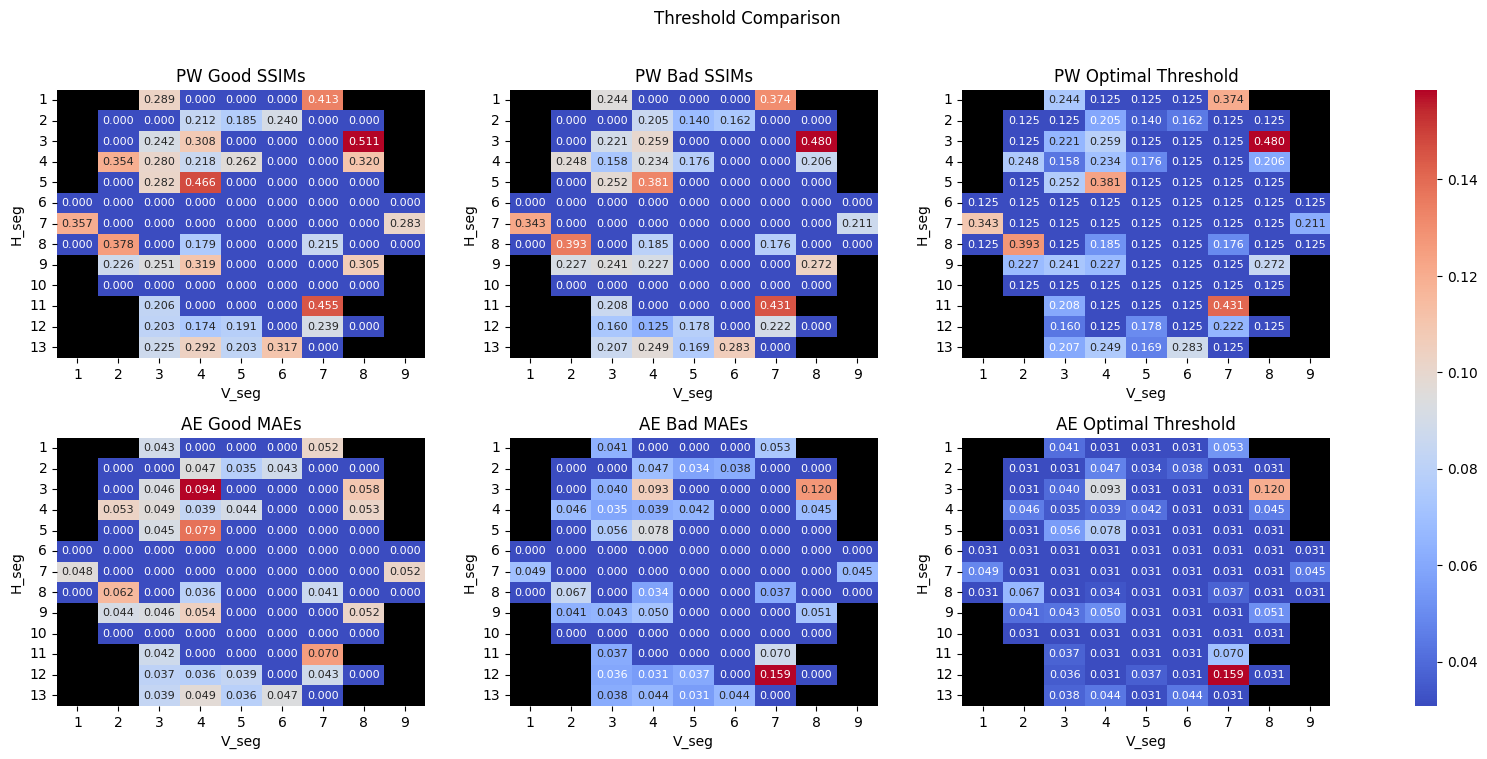

In [ ]:
# Visualize the threshold comparison for both methods
plot_threshold_comparison(
    pw_metrics=pw_metrics,
    ae_metrics=ae_metrics,
    skipped_segments=skipped_segments
)

In [ ]:
# Save the results to .npy files
np.save(os.path.join(str(CALIBRATION_DIR), 'pw_threshold.npy'), pw_metrics[0])
np.save(os.path.join(str(CALIBRATION_DIR), 'pw_bad_ssims.npy'), pw_metrics[1])
np.save(os.path.join(str(CALIBRATION_DIR), 'pw_good_ssims.npy'), pw_metrics[2])
np.save(os.path.join(str(CALIBRATION_DIR), 'ae_threshold.npy'), ae_metrics[0])
np.save(os.path.join(str(CALIBRATION_DIR), 'ae_bad_maes.npy'), ae_metrics[1])
np.save(os.path.join(str(CALIBRATION_DIR), 'ae_good_maes.npy'), ae_metrics[2])

### **2. Flag the Defective Segments**

In [4]:
# Load the thresholds
ae_threshold = np.load(os.path.join(str(CALIBRATION_DIR), 'ae_threshold.npy'))
pw_threshold = np.load(os.path.join(str(CALIBRATION_DIR), 'pw_threshold.npy'))

In [5]:
# Build a list of paths for all bad hexaboards
bad_data_dir = os.path.join(str(DATA_DIR), 'bad')
bad_hexaboard_paths = sorted(os.listdir(bad_data_dir))

# Build a mapping from bad filename basename -> list of true bad coords
true_bad_map = {}
with open(json_map_path, 'r') as f:
    bad_segments_mapping = json.load(f)['files']
    
for key, val in bad_segments_mapping.items():
    base = os.path.basename(key)
    coords = []
    for coord in val.get('damaged', []):
        coords.append((coord['row'], coord['col']))

    true_bad_map[base] = coords

# Derive extended skipped segments
bad_coords = {coord for coords in true_bad_map.values() for coord in coords}
all_coords = {(h, v) for h in range(H_seg) for v in range(V_seg)}
extended_skipped_segments = set(skipped_segments) | (all_coords - bad_coords)
len(extended_skipped_segments)

83

In [6]:
# Analyze the good hexaboards
ae_pred_good = []
pw_pred_good = []
double_pred_good = []
for hexaboard_path in good_hexaboard_paths:
    hexaboard = load_hexaboard(hexaboard_path)

    ae_indices = autoencoder_inference(
        hexaboard=hexaboard,
        threshold=ae_threshold,
        model=model,
        device=device,
        skipped_segments=extended_skipped_segments
    )
    pw_indices = pixelwise_inference(
        baseline_hexaboard=baseline_hexaboard,
        new_hexaboard=hexaboard,
        threshold=pw_threshold,
        skipped_segments=extended_skipped_segments
    )
    double_flagged_indices = sorted(list(set(ae_indices) & set(pw_indices)))

    ae_pred_good.append(ae_indices)
    pw_pred_good.append(pw_indices)
    double_pred_good.append(double_flagged_indices)

In [7]:
# Analyze the bad hexaboards
ae_pred_bad = []
pw_pred_bad = []
double_pred_bad = []
for filename in bad_hexaboard_paths:
    hexaboard_path = os.path.join(bad_data_dir, filename)
    hexaboard = load_hexaboard(hexaboard_path)

    ae_indices = autoencoder_inference(
        hexaboard=hexaboard,
        threshold=ae_threshold,
        model=model,
        device=device,
        skipped_segments=extended_skipped_segments
    )
    pw_indices = pixelwise_inference(
        baseline_hexaboard=baseline_hexaboard,
        new_hexaboard=hexaboard,
        threshold=pw_threshold,
        skipped_segments=extended_skipped_segments
    )
    double_flagged_indices = sorted(list(set(ae_indices) & set(pw_indices)))

    ae_pred_bad.append(ae_indices)
    pw_pred_bad.append(pw_indices)
    double_pred_bad.append(double_flagged_indices)

In [8]:
# Total segments per board (exclude skipped segments)
total_segments_per_board = H_seg * V_seg - len(extended_skipped_segments)
ae_cm = agg_confusion_matrix(
    bad_hexaboard_paths=bad_hexaboard_paths,
    pred_good_list=ae_pred_good,
    pred_bad_list=ae_pred_bad,
    true_bad_map=true_bad_map,
    total_per_board=total_segments_per_board
)
pw_cm = agg_confusion_matrix(
    bad_hexaboard_paths=bad_hexaboard_paths,
    pred_good_list=pw_pred_good,
    pred_bad_list=pw_pred_bad,
    true_bad_map=true_bad_map,
    total_per_board=total_segments_per_board
)
double_cm = agg_confusion_matrix(
    bad_hexaboard_paths=bad_hexaboard_paths,
    pred_good_list=double_pred_good,
    pred_bad_list=double_pred_bad,
    true_bad_map=true_bad_map,
    total_per_board=total_segments_per_board
)

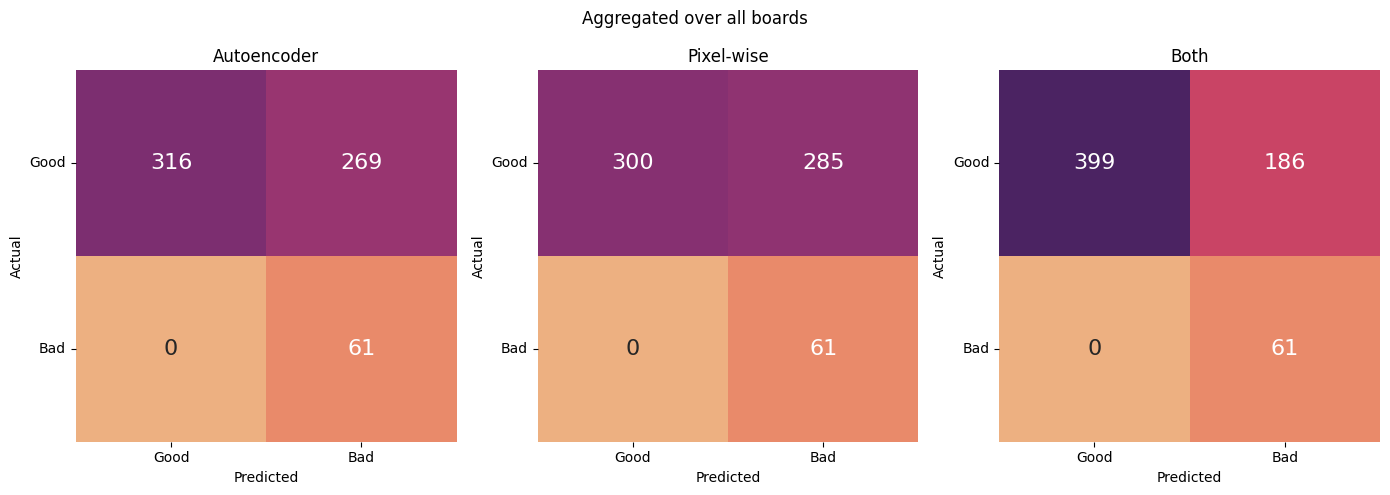

In [ ]:
# Plot the three confusion matrices
plot_confusion_matrices(
    ae_cm=ae_cm,
    pw_cm=pw_cm,
    double_cm=double_cm,
    title="Aggregated over all boards"
)